#Linear Regression

Simple linear regression with 1 variable

The data : Gender, Height (inch), weight (lbs)

In [1]:
!wget https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv

--2023-06-23 01:09:45--  https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418120 (408K) [text/plain]
Saving to: ‘weight-height.csv’

weight-height.csv   100%[===================>] 408.32K  --.-KB/s    in 0.04s   

2023-06-23 01:09:45 (9.36 MB/s) - ‘weight-height.csv’ saved [418120/418120]



##Instal package

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=da9b2c300748369827147d71dbcf0f3b9d763ea28b71265e5c4f9a428bc2ffa4
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MlLib - Machine Learning').getOrCreate()

##Loading data

In [4]:
df = spark.read.csv(path='weight-height.csv', sep=',', header = True, inferSchema = True)

##Eksplorasi

In [5]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- Gender: string (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)

+------+----------------+----------------+
|Gender|          Height|          Weight|
+------+----------------+----------------+
|  Male| 73.847017017515|241.893563180437|
|  Male|68.7819040458903|  162.3104725213|
|  Male|74.1101053917849|  212.7408555565|
|  Male|71.7309784033377|220.042470303077|
|  Male|69.8817958611153|206.349800623871|
+------+----------------+----------------+
only showing top 5 rows

+-------+------+-----------------+------------------+
|summary|Gender|           Height|            Weight|
+-------+------+-----------------+------------------+
|  count| 10000|            10000|             10000|
|   mean|  null|66.36755975482106|161.44035683283076|
| stddev|  null|3.847528120773333|32.108439006519674|
|    min|Female| 54.2631333250971|   64.700126712753|
|    max|  Male| 78.9987423463896|  269.989698505106|
+-------+------+-----------------+--

First we plot the data with `scatterplot`. Since the data is quite big, we will sample 100 data point randomly using dataframe's `sample` function.

<Axes: xlabel='Weight', ylabel='Height'>

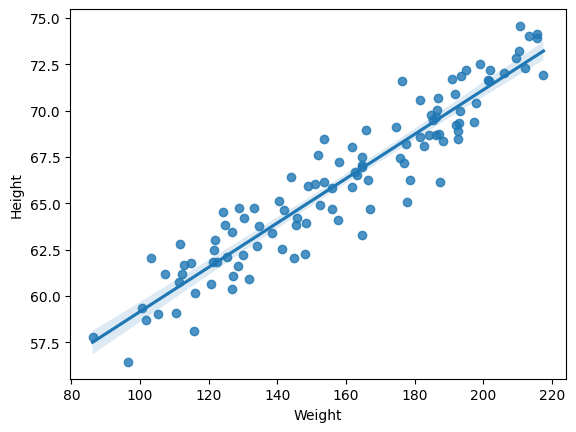

In [6]:
import seaborn as sns
import pandas as pd

sample = df.sample(fraction=.01)
pdf = sample.toPandas()

sns.regplot(x='Weight', y='Height', data=pdf)
#sns.scatterplot(x='Weight', y='Height', data=pdf)

In [7]:
df_selected = df.select(["Weight", "Height"])
df_selected.show(5)

+----------------+----------------+
|          Weight|          Height|
+----------------+----------------+
|241.893563180437| 73.847017017515|
|  162.3104725213|68.7819040458903|
|  212.7408555565|74.1101053917849|
|220.042470303077|71.7309784033377|
|206.349800623871|69.8817958611153|
+----------------+----------------+
only showing top 5 rows



In [8]:
from pyspark.sql.functions import col

features = ['Weight']
label = 'Height'

df_selected = df.select(*features, col(label).alias("label"))
(training, test) = df_selected.randomSplit([.7, .3])

In [9]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
training = vectorAssembler.transform(training)
training.show(5, False)

+----------------+----------------+------------------+
|Weight          |label           |features          |
+----------------+----------------+------------------+
|68.9825300912419|55.6682021205121|[68.9825300912419]|
|71.393748738973 |54.6168578301035|[71.393748738973] |
|72.7501446905149|57.353092760465 |[72.7501446905149]|
|77.8985592718359|56.1672991862273|[77.8985592718359]|
|78.6066703120237|54.8737275315254|[78.6066703120237]|
+----------------+----------------+------------------+
only showing top 5 rows



In [10]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.10217956968561157]
Intercept: 49.870489203562514
numIterations: 2
objectiveHistory: [0.5, 0.42050726189336074, 0.13451545607882917]
+------------------+
|         residuals|
+------------------+
|-1.250892323598265|
|-2.548613897849947|
|0.0490250778596959|
|-1.662831282860516|
|-3.028757418938433|
+------------------+
only showing top 5 rows

RMSE: 1.499641
r2: 0.848046


In [11]:
#prediction
test = vectorAssembler.transform(test)
predictions = lrModel.transform(test)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)


Model Prediction Result :  
+------------------+----------------+------------------+
|          features|           label|        prediction|
+------------------+----------------+------------------+
| [64.700126712753]|54.2631333250971|56.481520309676156|
|[77.5237739030693]|58.2116499335358| 57.79183506138278|
|[79.1743758333647]|56.7644564465812|57.960492856342604|
|[83.9930774713752]|56.7854343692644|58.452865716157866|
|[84.8721236452797]|56.5479749809036| 58.54268627594121|
+------------------+----------------+------------------+
only showing top 5 rows



In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)


Root Mean Squared Error (RMSE) on test data = 1.46741
R-Squared on test data = 0.854538


We can consider other variable (in this case 'Gender') as additional input variable to predict height. First let's plot the data.
We will use the same sample data we took from before.

<Axes: xlabel='Weight', ylabel='Height'>

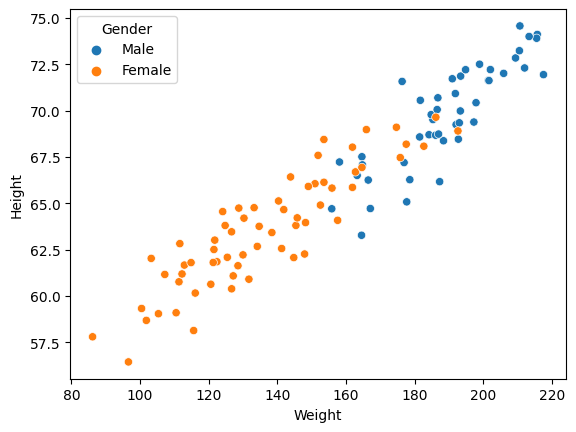

In [13]:
sns.scatterplot(x="Weight", y="Height", hue="Gender", data=pdf)

Split the data into training-test set

In [14]:
features = ['Weight', 'Gender']
label = 'Height'

(training_, test_) = df.randomSplit([.7, .3])

Since Gender is a categorical variable, we need to transform it to numeric using `StringIndexer` and `OneHotEncoder`

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

indexer = StringIndexer(inputCol="Gender", outputCol="Gender_idx")

# default setting: dropLast=True
encoder = OneHotEncoder(inputCol="Gender_idx",
      outputCol="Gender_encoded".format(indexer.getOutputCol()))

assembler = VectorAssembler(inputCols=["Weight", "Gender_encoded"], outputCol="features")

pipeline = Pipeline(stages=[indexer, encoder, assembler])
model = pipeline.fit(training_)
output = model.transform(training_)

output.show(5)

training = output.select("features", col(label).alias("label"))
training.show(5)

+------+----------------+----------------+----------+--------------+--------------------+
|Gender|          Height|          Weight|Gender_idx|Gender_encoded|            features|
+------+----------------+----------------+----------+--------------+--------------------+
|Female|54.6168578301035| 71.393748738973|       1.0|     (1,[],[])|[71.393748738973,...|
|Female|54.8737275315254|78.6066703120237|       1.0|     (1,[],[])|[78.6066703120237...|
|Female|55.1485573624105| 88.812412112758|       1.0|     (1,[],[])|[88.812412112758,...|
|Female|55.6518916024929|85.6217764414627|       1.0|     (1,[],[])|[85.6217764414627...|
|Female|55.6682021205121|68.9825300912419|       1.0|     (1,[],[])|[68.9825300912419...|
+------+----------------+----------------+----------+--------------+--------------------+
only showing top 5 rows

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[71.393748738973,...|54.6168578301035|
|[78.

In [16]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.1016752791489707,0.0]
Intercept: 49.95113364039244
numIterations: 10
objectiveHistory: [0.4999999999999716, 0.4051574947620004, 0.16902239069894942, 0.1599229379500283, 0.13966842461537068, 0.13535369390293292, 0.1350023922566711, 0.1349840805848242, 0.13498312608512347, 0.1349830763316205, 0.13498307373824392]
+-------------------+
|          residuals|
+-------------------+
| -2.593255142815501|
|-3.0697612558131624|
|-3.8326030714400403|
|-3.0048600588160213|
|-1.2967495233096358|
+-------------------+
only showing top 5 rows

RMSE: 1.497850
r2: 0.847412


In [17]:
#prediction
output = model.transform(test_)
test = output.select("features", col(label).alias("label"))
test.show(5, truncate=False)


predictions = lrModel.transform(test)

# Select example rows to display.
print("\nModel Prediction Result :  ")
predictions.select("features","label","prediction").show(5)

+----------------------+----------------+
|features              |label           |
+----------------------+----------------+
|[64.700126712753,0.0] |54.2631333250971|
|[88.3665825783999,0.0]|55.336492408949 |
|[90.8152556552271,0.0]|56.1594580191187|
|[97.7438964834685,0.0]|56.5341658080891|
|[79.1743758333647,0.0]|56.7644564465812|
+----------------------+----------------+
only showing top 5 rows


Model Prediction Result :  
+--------------------+----------------+------------------+
|            features|           label|        prediction|
+--------------------+----------------+------------------+
|[64.700126712753,...|54.2631333250971|56.529537084885376|
|[88.3665825783999...| 55.336492408949| 58.93583059149182|
|[90.8152556552271...|56.1594580191187|59.184800110122794|
|[97.7438964834685...|56.5341658080891|  59.8892716004572|
|[79.1743758333647...|56.7644564465812|58.001210404695314|
+--------------------+----------------+------------------+
only showing top 5 rows



In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator1 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")
rmse1 = evaluator1.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1)

evaluator2 = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="r2")
r21 = evaluator2.evaluate(predictions)
print("R-Squared on test data = %g" % r21)


Root Mean Squared Error (RMSE) on test data = 1.48244
R-Squared on test data = 0.853797
